# Computer Vision: Advanced CNNs

In this notebook, we will use a pre-trained model to separate images of cats and dogs. We begin with installing our routine packages and importing them:

### 0. Install/ Import Packages:

In [1]:
# !pip install keras
# !pip install tensorflow
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 81.3 MB/s eta 0:00:00:00:0100:01


In [6]:
# IPython display functions
import IPython
from IPython.display import display, HTML, SVG, Image

# General Plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

## notebook style and settings
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))

# For changing background color
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.backend import clear_session
from sklearn.metrics import classification_report,confusion_matrix

import pandas as pd
import numpy as np
import os

2025-03-05 22:46:31.490858: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 22:46:31.492169: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 22:46:31.494960: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 22:46:31.502949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741214791.516623     576 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741214791.52

### 1. Loading the Pre-trained Model

Now it's time for us to load the pre-trained CNN model. The list of pre-trained CNN models that are available in Keras can be found here: https://keras.io/api/applications/

From this list, we select vgg16 as the pre-trained model to be used in our image classification task. VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition". The original paper explaining the model can be found here: https://arxiv.org/abs/1409.1556. More documentations regarding the implementation of the model can be found: https://keras.io/api/applications/vgg/#vgg16-function.

Now, let's go ahead and load the model (including its weights). We can also use summary() to see the architecture of the network:

In [9]:
vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(weights='imagenet')
vgg.summary()

2025-03-05 22:46:44.511333: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

**Quiz:** How many convolutional layers do we have in VGG16? 

Here is a graphic visualization of VGG16:

<img src="https://www.researchgate.net/profile/Mengyun-Liu-4/publication/327060416/figure/fig1/AS:660427612622849@1534469621448/Architecture-of-VGG16.png">
<hr>
<center><b>VGG16 Architecture</b></center>

As you can see in the VGG16 architecture above, the convolutional layers are connected to a fully connected feed-forward network (on the right). Given that we want to use our own training data to fine-tune the model, we don't load the feed-forward layers from VGG16. Rather, we only load the convolutional layers (as well as pooling layers) from VGG16 so that we can add our own feed-forward layers later on.   

In [10]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', 
                         include_top=False # Don't load the feed-forward layers
                         , input_shape=(224,224,3) # The shape of the input data (images)
                        )
conv_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Pre-process the Image Data:

So far, we loaded our pre-trained model. Now, we need to make sure that our image data are in the format that can be processed by VGG16. VGG16 accept images of size 224 by 224. We use the following function called "generators" to load and process the data. The images are in two separate folders: dogs and cats.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 10

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, # Randomly flip inputs horizontally.
        validation_split = 0.1, # Use 10% of images for validation
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('dogs','cats'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('dogs','cats'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

The inputs to the "generators" function that we defined above are shape and preprocessing. The shape input will determine the desired shape of the images that will be fed to the model. VGG16 works with 224 by 224 images. Therefore, we set the shape to be equal to (224,224).

The next input is preprocessing, which is the desired pre-processing method. The good news is that VGG16 comes with own pre-processing methods. Therefore, we use VGG16's pre-processing methods to pre-process the images in our sample: 

In [12]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg16.preprocess_input)

Found 180 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


### 3. Add the New Layers to the Pre-trained Model:

Now, we need to work on connecting our own feed-forward layers to the CNN layers of VGG16. As we discussed before, we need to flatten the output of the convolutional layers before connecting them to the feed-forward layer(s). 

In [13]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)

After flattening, we can add the feed-forward layers:

In [14]:
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)

And finally, we add the output layer:

In [15]:
# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(2, activation='softmax')(x)

Let's go ahead and put everything together:

In [16]:
# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,243,990 (65.78 MB)

 Trainable params: 17,243,990 (65.78 MB)

 Non-trainable params: 0 (0.00 B)

Before starting the training, we make sure that the model does not update the weights in the convolutional layers that we obtained from VGG16:

In [17]:
for layer in conv_model.layers:
    layer.trainable = False

Let's check the full model again (pay attention to "Non-trainable params"):

In [18]:
full_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,243,990 (65.78 MB)

 Trainable params: 2,529,302 (9.65 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 4. Compile and Run:

We can go ahead and compile and train the model:

In [19]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])

history = full_model.fit(train_dataset,steps_per_epoch=20,
                                validation_data= val_dataset, 
                                validation_steps=10,
                                epochs=2)

Epoch 1/2


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/20 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - acc: 0.6622 - loss: 4.3946

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - acc: 0.6738 - loss: 4.2827 - val_acc: 0.8889 - val_loss: 1.2178
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.9477 - loss: 0.6378 - val_acc: 0.9444 - val_loss: 0.1393


We can define and use the following function to visualize the a new function to visualize the performance of the model as measured by accuracy (the higher, the better) and loss (the lower, the better).

In [21]:
history.history

{'acc': [0.7777777910232544, 0.949999988079071],
 'loss': [3.2751994132995605, 0.8292531371116638],
 'val_acc': [0.8888888955116272, 0.9444444179534912],
 'val_loss': [1.2177560329437256, 0.13931094110012054]}

### 5. Make Predictions on New Images:

We can now make predictions using the model. We need to pre-process the new images the same way we did before:

In [22]:
from keras.preprocessing import image

img_path = 'dogs/dog.1.jpg'

# loading the image: 
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))

# turn it into a numpy array
x = tf.keras.utils.img_to_array(img)

# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)

# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)

xs is the name of the processed image. We can now use the model to get the prediction for this image:

In [23]:
np.argmax(full_model.predict(xs), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


array([0])

This image is predicted to belong to class 0 (dogs). Let's see if it really was a dog:

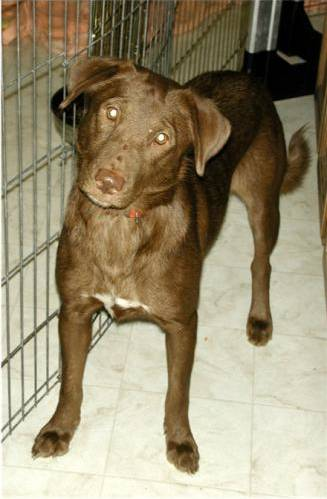

In [24]:
from IPython.display import Image
Image(filename=img_path) 

We can check an image from our cat collection (in case you are more of a cat person!) as well:

In [25]:
from keras.preprocessing import image

img_path = 'cats/cat.1.jpg'

# loading the image: 
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))

# turn it into a numpy array
x = tf.keras.utils.img_to_array(img)

# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)

# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)

In [26]:
np.argmax(full_model.predict(xs), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


array([1])

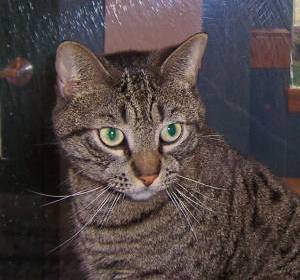

In [27]:
from IPython.display import Image
Image(filename=img_path) 

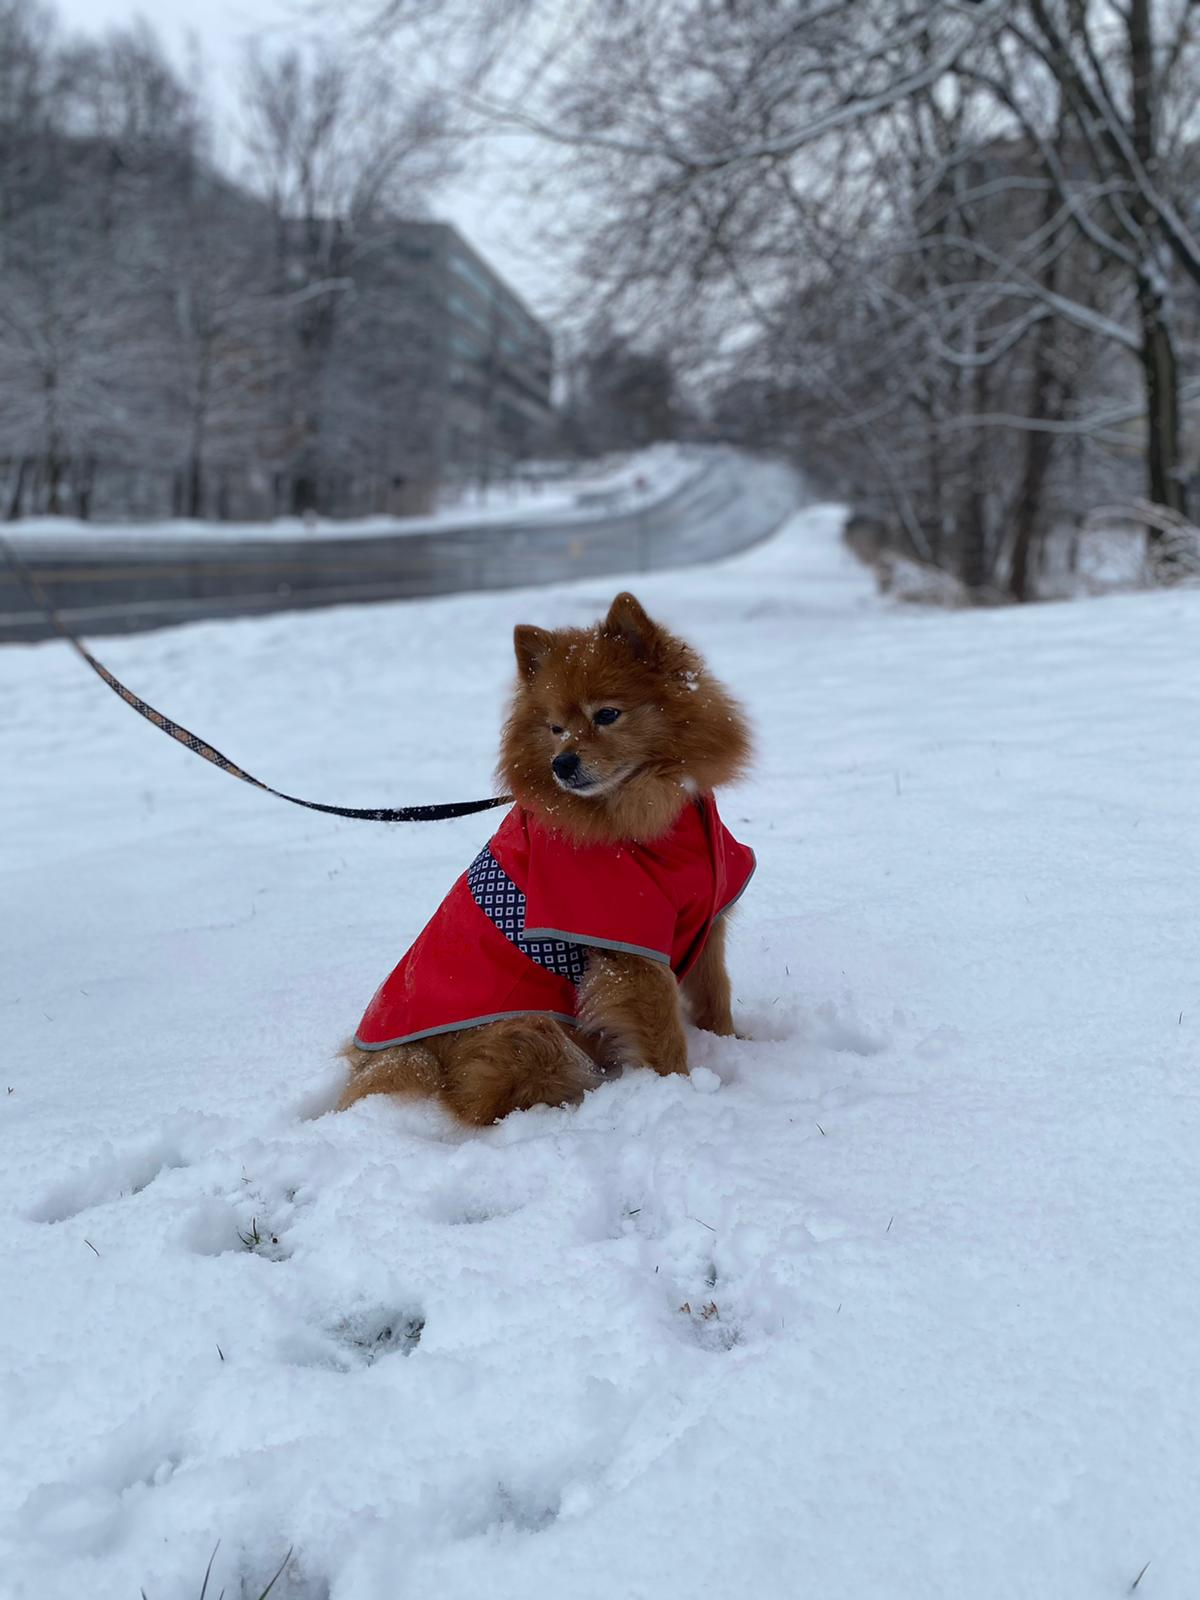

In [28]:
from IPython.display import Image
Image(filename='test_dog.JPG') 

In [29]:
from keras.preprocessing import image

img_path = 'test_dog.JPG'

# loading the image: 
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))

# turn it into a numpy array
x = tf.keras.utils.img_to_array(img)

# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)

# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)

if np.argmax(full_model.predict(xs), axis=-1) ==0:
    print("This is a dog.")
else: 
    print("This is a cat.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
This is a dog.


## Gender Detection with CIFAR Data:

In this section, we create a real-world application for detecting subject's gender using pre-trained VGG16 model and labeled data from CIFAR100. More information about CIFAR data is available here: https://www.cs.toronto.edu/%7Ekriz/cifar.html or https://paperswithcode.com/dataset/cifar-100

We load CIFAR data from Keras datasets:

In [30]:
(trainImages, trainLabels), (testImages, testLabels) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Let's look at the shape of this data:

In [31]:
trainImages.shape

(50000, 32, 32, 3)

There are 50K images in the training set. Image is 32 by 32 pixels and has three colors (channels).

CIFAR100 includes labeled images for 100 different categories. We only want to use images with labels "Male" and "Female". We go ahead and subset CIFAR to exclude any image that doesn't have "Male" or "Female" labels:

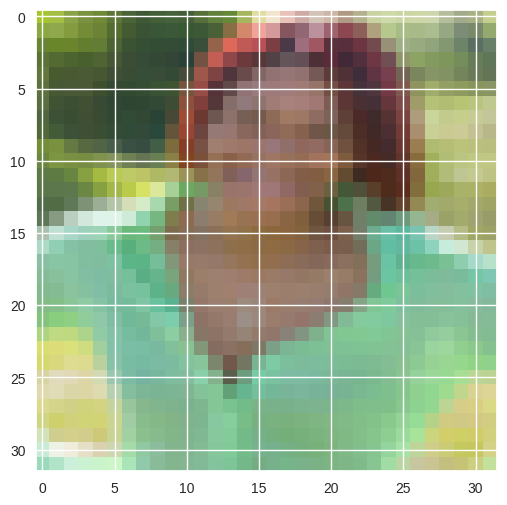

In [32]:
female_train = pd.DataFrame(zip(trainImages,trainLabels.ravel()), columns=['image','label']).query('label==98')
female_test = pd.DataFrame(zip(testImages,testLabels.ravel()), columns=['image','label']).query('label==98')
plt.imshow(female_train.image.iloc[0])

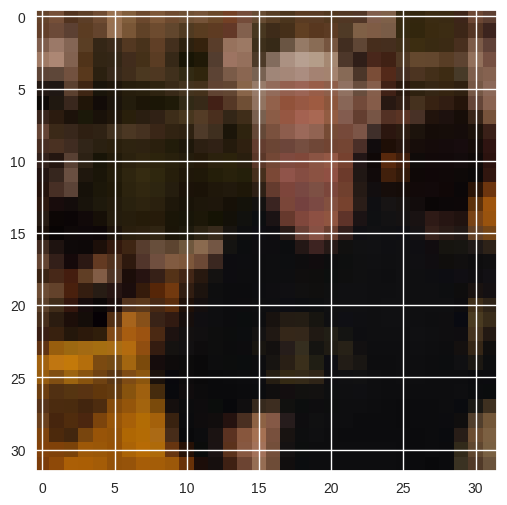

In [33]:
male_train = pd.DataFrame(zip(trainImages,trainLabels.ravel()), columns=['image','label']).query('label==46')
male_test = pd.DataFrame(zip(testImages,testLabels.ravel()), columns=['image','label']).query('label==46')
plt.imshow(male_train.image.iloc[0])

We can go ahead and load VGG16:

In [34]:
clear_session()
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', 
                         include_top=False # Don't load the feed-forward layers
                         , input_shape=(224,224,3) # The shape of the input data (images)
                        )
conv_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

We can go ahead and add the flatten and dense layers:

In [35]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)

# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)

# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(2, activation='softmax')(x)

# creating the full model:
gen_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

Since we don't want to update the weights in the pre-trained model, we run:

In [36]:
for layer in conv_model.layers:
    layer.trainable = False

In [37]:
gen_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,243,990 (65.78 MB)

 Trainable params: 2,529,302 (9.65 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Now, we go ahead and prepare the data for the model. We first change the shape from (32,32,3) to (224,224,3):

In [38]:
def pro_image_vgg16(img):
    temp = cv2.resize(img,(224,224),3)
    return vgg16.preprocess_input(temp)

female_train['image'] = female_train.image.apply(lambda x: pro_image_vgg16(x))
female_test['image'] = female_test.image.apply(lambda x: pro_image_vgg16(x))
male_train['image'] = male_train.image.apply(lambda x: pro_image_vgg16(x))
male_test['image'] = male_test.image.apply(lambda x: pro_image_vgg16(x))

np.shape(female_train['image'].iloc[0])

(224, 224, 3)

Now we put all images from female and male subjects in the same train and test data sets:

In [39]:
train_data = pd.concat([female_train,male_train])
test_data = pd.concat([female_test,male_test])

We also make sure our labels are properly formatted. Given that we use two units (one for female and one for male) in the output layer, we encode the original labels such that they are compatible with the CNNs output layer. This means, we should have the following format for the labels: [0,1] for female and [1,0] for male:

In [40]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

train_data['label']= label_encoder.fit_transform(train_data['label'])
test_data['label']= label_encoder.fit_transform(test_data['label'])

trainLabels = keras.utils.to_categorical(train_data['label'], 2)
testLabels = keras.utils.to_categorical(test_data['label'], 2)

Now, we can go ahead and train the model. In a real-world application, we use many epochs to make sure the model is properly trained. However, here, we only use a couple of epochs to save time: 

In [41]:
gen_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])

history = gen_model.fit(np.array(train_data.image.to_list()), 
                        trainLabels, validation_split = 0.2, batch_size=32, epochs=3, verbose=1)

Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - acc: 0.6011 - loss: 2.4151 - val_acc: 0.8500 - val_loss: 0.4076
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - acc: 0.8631 - loss: 0.2876 - val_acc: 0.5550 - val_loss: 1.3508
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 158s 6s/step - acc: 0.9937 - loss: 0.0357 - val_acc: 0.5950 - val_loss: 1.1924


We can check the predictive performance of the model:

In [42]:
history.history

{'acc': [0.6499999761581421, 0.8924999833106995, 0.9937499761581421],
 'loss': [1.562983751296997, 0.23882335424423218, 0.032115790992975235],
 'val_acc': [0.8500000238418579, 0.5550000071525574, 0.5950000286102295],
 'val_loss': [0.40762385725975037, 1.3508113622665405, 1.1923521757125854]}

Let's go ahead and try getting predictions for a new image:

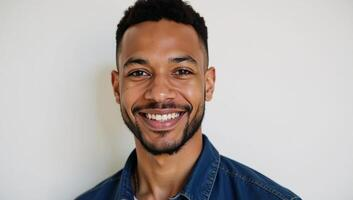

In [49]:
from IPython.display import Image
Image(filename='test_male.jpg') 

In [50]:
from keras.preprocessing import image

img_path = 'test_male.jpg'

# loading the image: 
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))

# turn it into a numpy array
x = tf.keras.utils.img_to_array(img)

# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)

# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)

if np.argmax(gen_model.predict(xs), axis=-1) ==0:
    print("The subject's gender is 'Male'")
else: 
    print("The subject's gender is 'Female'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
The subject's gender is 'Male'


And here is another example:

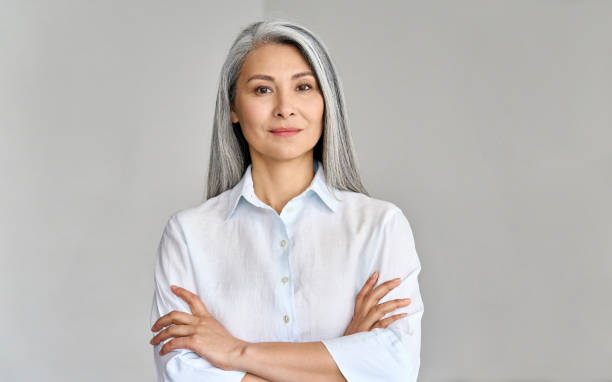

In [45]:
from IPython.display import Image
Image(filename='istockphoto-1317784594-612x612.jpg') 

In [46]:
from keras.preprocessing import image

img_path = 'test_female.jpg'

# loading the image: 
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))

# turn it into a numpy array
x = tf.keras.utils.img_to_array(img)

# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)

# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)

if np.argmax(gen_model.predict(xs), axis=-1) ==0:
    print("The subject's gender is 'Male'.")
else: 
    print("The subject's gender is 'Female'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
The subject's gender is 'Female'.
